# Case 2: Cluster of stores

Idea to form clusters from the best performing stores and worst performing stores with respect to the sales volume. The top 3 best stores with highest sales values and bottom 3 stores with the lowest sales values are clustered together to build a machine learning model and forecast the future sales.

Since, we saw the range of sales are different for a certain group of stores (from the last plot in the exploratory analysis notebook). The motivation behind making such a cluster is to find out if the difference in range of sales values affect the quality of predictions.

OBSERVATION: This idea of decentralization/ clustering can be beneficial in two ways:
1. Reduces the waiting time to obtain results as processing the data for all stores take time as we will be handling large volumes of data at once. If we do not have access to faster computing machines, this will be a problem and a slow process. Time is money! De-centralizing will split the data (say, in half) depending upon the chosen cluster of stores. We focus on those small clusters and hence faster processing.

2. In business perspective, the sales forecasting for some stores might be more important. For examples, stores present in Paris would handle huge volumes of inventory than stores present in Saint-Etienne. Therefore, making clusters based on handling the volumes of data might be a good idea as we can focus more on highly active stores which bring more customers. More sales are more profit. This should be the first priority and the less active stores can be handled next. This can be an example for profit maximization.

Similar to the clustering of stores, we can even take a step further and cluster items too (based on their sales volume).

This could be called as a Tier-2 Decentralized Sales Model (based on sales activity of stores and items). Similar to the above case, we decentralize based on stores' sales handling capacity and also on most sold items.
This way we can make a 4-way split:
1. High volume stores + High volume items
2. High volume stores + Low volume items
3. Low volume stores + High volume items
4. Low volume stores + Low volume items

This tier-2 decentralized model could work well as we can focus more on (1,2 and maybe 3) depending upon other factors too. So the idea is to focus more on places where we would find more profits.



In [ ]:
pip install optuna # optuna is a library to tune hyperparameters more efficiently

In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from time import time
import pickle
import catboost as cb
import lightgbm as lgb

In [ ]:
# loading data using pandas

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
def datetime(df):
  '''
  Method to convert the date column which 
  would be easily understood by pandas
  '''
  df.date = pd.to_datetime(df.date).values
  temp = df.set_index('date', drop=True)

  return temp

train = datetime(train) 
test = datetime(test)

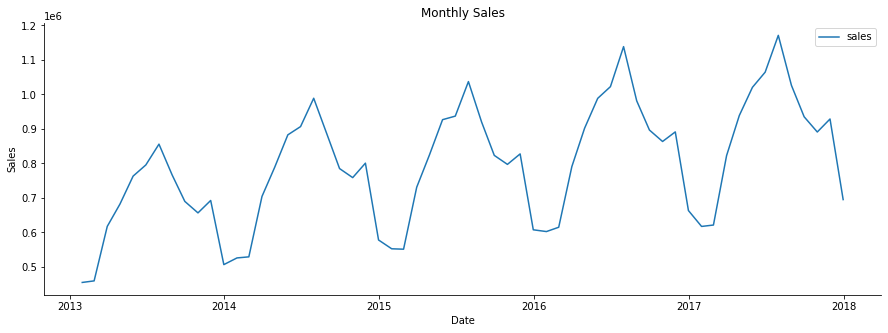

In [ ]:
'''
Plot of monthly sales values (aggregated for all stores and items)
'''

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=train, ax=ax, 
             color='blue')

ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = "Monthly Sales")

sns.despine()

# Feature Engineering

In order to keep it simple, I used the date related feature engineering and also 4 different types of machine learning methods which work well on time series data.

The predictions were made in 3 different ways:
1. Daily predictions for the two store clusters
2. Weekly predictions
3. Monthly predictions

This is done to test the robustness of prediction methods in handling different frequencies of time series data.



In [ ]:
# Feature engineering

'''
Using date as X feature and sales as y feature
'''

def date_related_features(df):
  '''
  Converts date feature into smaller parts and 
  adds as additional features to the dataset
  '''
  df['day_in_month'] = np.array(df.index.day.values) # number of days in the month
  df['month'] = np.array(df.index.month.values) # adds month feature
  df['day_in_year'] = np.array(df.index.dayofyear.values) # number of days in the year
  df['day_of_week'] = np.array(df.index.dayofweek.values) # day numbers in the week
  df['week_in_year'] = np.array(df.index.isocalendar().week.values).astype('int') # week numbers in the year
  df['date_diff'] = np.array((df.index - df.index[0]).days) # no. of days from start
  df['quarter'] = np.array(df.index.quarter) # date belongs to which quarter of year
  df['weekend'] = np.array(np.floor_divide(df.index.dayofweek,4)) # if its a weekend or not
  #df['year'] = np.array(df.index.year) # date belongs to which quarter of year
  #df['monthstart'] = np.array(df.index.is_month_start.astype(int)) # 1 if the day is start of month
  #df['monthend'] = np.array(df.index.is_month_end.astype(int)) # 1 if the day is start of month

  return df


# change the resample value to 'D' for daily, 'W' for weekly, 'M' for monthly

best_stores_train = train.query('store==[2,8,3]').resample('D').sum().drop(['store','item'],axis=1)
best_stores_test = test.query('store==[2,8,3]').resample('D').sum().drop(['store','item'],axis=1)

worst_stores_train = train.query('store==[7,6,5]').resample('D').sum().drop(['store','item'],axis=1)
worst_stores_test = test.query('store==[7,6,5]').resample('D').sum().drop(['store','item'],axis=1)

best_stores_train = date_related_features(best_stores_train)
best_stores_test = date_related_features(best_stores_test)

worst_stores_train = date_related_features(worst_stores_train)
worst_stores_test = date_related_features(worst_stores_test)

# Model Training

I made a bigger loop to train multiple models, perform hyperparameter tuning on each model with 100 trials and select the best model based on validation score to predict on validation set and also the test set.

The 4 machine learning methods which used in this experiments are:
1. Random Forest Regressor
2. XGBoost Regressor
3. CatBoost Regressor
4. LightGBM Regressor


In [ ]:

def train_model(df_train_data, df_test_data, types):

  '''
  This method performs train, validation split and does the training, hyperparameter
  tuning and finally outputs the metrics on validation predictions.

  Also we save all the relevant visualizations.
  '''

  # data split: train and validation

  '''
  The last 3 months of the train data are used as validation set
  The test set also consists of 3 months related data
  '''

  df_train = df_train_data.iloc[df_train_data.index < "2017-01-31", :]

  df_valid = df_train_data.iloc[df_train_data.index >= "2017-01-31", :]

  '''
  X features and y features are separated for train and valid data
  '''

  feature_columns = [i for i in df_train_data.columns if i not in ['id', "sales"]]

  x_train = df_train[feature_columns]
  y_train = df_train.sales

  x_valid = df_valid[feature_columns]
  y_valid = df_valid.sales

  df_test = df_test_data[feature_columns]

  def randomforest(trial):
    max_depth = trial.suggest_int("max_depth", 2, 50,step=8, log=False)
    n_estimators = trial.suggest_int("n_estimators", 100, 500,step=100, log=False)
    model = RandomForestRegressor(max_depth=max_depth,n_estimators=n_estimators)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_valid)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    trial.set_user_attr(key="best_booster", value=model)
    return mean_absolute_error(y_valid, y_pred)


  def xgboost_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 50,step=8, log=False)
    n_estimators = trial.suggest_int("n_estimators", 100, 500,step=100, log=False)
    model = xgboost.XGBRegressor(objective ='reg:squarederror',max_depth=max_depth,n_estimators=n_estimators)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_valid)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    trial.set_user_attr(key="best_booster", value=model)
    return mean_absolute_error(y_valid, y_pred)


  def catboost_model(trial):
    iterations = trial.suggest_int("iterations", 100, 500,step=100, log=False)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    model = cb.CatBoostRegressor(loss_function='MAE')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_valid)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    trial.set_user_attr(key="best_booster", value=model)
    return mean_absolute_error(y_valid, y_pred)

  def lightgbm_model(trial):
    lgb_train = lgb.Dataset(x_train, label=y_train)
    iterations = trial.suggest_int("iterations", 100, 500,step=100, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 50,step=8, log=False)
    model = lgb.train({'max_depth':max_depth}, lgb_train, iterations)
    y_pred = model.predict(x_valid)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    trial.set_user_attr(key="best_booster", value=model)
    return mean_absolute_error(y_valid, y_pred)

  def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

  df_test_new = df_test.copy()
  scores = {}
  method = [randomforest,xgboost_model,catboost_model,lightgbm_model]
  models = ['randomforest','xgboost','catboost','lightgbm']

  for i in range(0,4):

    study = optuna.create_study(direction="minimize")
    study.optimize(method[i], n_trials=100, timeout=None, callbacks=[callback])
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    best_params = study.best_trial.params

    best_model = study.user_attrs['best_booster']
    y_pred = best_model.predict(x_valid)
    y_pred_test = best_model.predict(df_test)
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = sqrt(mean_squared_error(y_valid, y_pred))
    r2score = r2_score(y_valid, y_pred)
    df_valid['pred'] = y_pred
    df_test_new['pred'] = y_pred_test

    scores[models[i]] = [mae,rmse,r2score]

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(data=df_train_data.sales, ax=ax, 
                  label='Original', color='blue')
    sns.lineplot(data=df_valid.pred, ax=ax, 
                  label='Validation Predicted', color='Red')
    sns.lineplot(data=df_test_new.pred, ax=ax, 
                  label='Test Predicted', color='green')


    ax.set(xlabel = "Date",
            ylabel = "Sales",
            title = f"Sales Forecasting Using {models[i]} (cluster)")

    ax.legend()
    plt.savefig( f'images/cluster-{types}-{models[i]}.jpg', bbox_inches='tight', dpi=200)

    sns.despine()

  scores_df = pd.DataFrame(scores)
  scores_df.index = ['mae','rmse','r2']

  return scores_df


In [ ]:
# model training for best stores cluster

scores_best_stores = train_model(best_stores_train,best_stores_test,"beststores")

In [ ]:
# model training for worst stores cluster

scores_worst_stores = train_model(worst_stores_train,worst_stores_test,"worststores")

# Metrics on experiments 

Here, on the validation set, we make daily predictions, weekly predictions and monthly predictions.

Observation:

Most of the algorithms perform better with daily predictions. This could be because there is significant reduction in the training data when we resample data into weekly and monthly frequencies.

Machine learning models usually require more data to build a better performing model.

More experiments should be performed with different feature engineering methods to check the viability of weekly and monthly predictions.


In [ ]:
scores_best_stores # daily frequency predictions

,randomforest,xgboost,catboost,lightgbm
mae,461.558289,552.057616,360.261442,358.611015
rmse,549.292332,664.487923,403.920515,428.958360
r2,0.938238,0.909616,0.966603,0.962334


In [ ]:
scores_worst_stores # daily frequency predictions

,randomforest,xgboost,catboost,lightgbm
mae,280.648597,356.413516,232.608803,218.544917
rmse,339.809329,432.718791,265.572377,256.929957
r2,0.936592,0.897179,0.961271,0.963751


In [ ]:
scores_best_stores # monthly frequency predictions

,randomforest,xgboost,catboost,lightgbm
mae,17810.104167,15530.083333,18169.803497,47107.419954
rmse,22968.081732,17586.782467,22563.045440,51352.369430
r2,0.859556,0.917657,0.864465,0.297937


In [ ]:
scores_worst_stores # monthly frequency predictions

,randomforest,xgboost,catboost,lightgbm
mae,10970.428333,9604.871094,10994.304319,28806.658740
rmse,14373.011544,11517.193371,14098.649973,31424.972375
r2,0.853784,0.906116,0.859313,0.301046


In [ ]:
scores_best_stores # weekly frequency predictions

,randomforest,xgboost,catboost,lightgbm
mae,3357.781667,5254.384847,3149.292805,2963.642021
rmse,3840.828562,6441.276326,3307.584488,3626.268171
r2,0.896770,0.709665,0.923444,0.907981


In [ ]:
scores_worst_stores # weekly frequency predictions

,randomforest,xgboost,catboost,lightgbm
mae,1941.293750,4183.476562,1868.126862,1731.965700
rmse,2284.797674,4655.787005,1982.858675,2163.713244
r2,0.903535,0.599447,0.927346,0.913489
